<a href="https://colab.research.google.com/github/JohanEstebanCuervo/Comunicaciones_Digitales/blob/main/Quadrature_Amplitude_Modulation_(QAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias a utilizar

In [2]:
!pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg 
from math import ceil,floor
from commpy.modulation import QAMModem
from commpy.filters import rrcosfilter
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

In [3]:
def Grafica_PSD(signal,Fs,title='Espectro de Potencia'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  plt.figure(figsize=(16,9))
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title(title,fontsize = 20)
  plt.grid()
  plt.show()

def eyediagram(signal,muestras_simbolo,title='Diagrama de ojo'):

  inicio=muestras_simbolo//2+1

  plt.figure(figsize=(16,9))
  plt.title(title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()

  signal=np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

def Grafica_PSD_eyediagram(signal,Fs,muestras_simbolo,title='Señal'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  fig= plt.figure(figsize=(25,6))
  plt.subplot(1,2,1)
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title('Espectro de Potencia '+ title,fontsize = 20)
  plt.grid()

  plt.subplot(1,2,2)
  inicio=muestras_simbolo//2+1
  plt.title('Diagrama de ojo ' + title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()
  signal = np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

  plt.show

def Graficas_PSK(modulador):
  fig = plt.figure(figsize=(15,15))

  ################## Primer plot Bits ##########################################
  plt.subplot(6,1,1)
  markerline, stemlines, baseline =plt.stem(np.arange(1,len(modulador.bits)+1), modulador.bits, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Bits',fontsize = 14)
  xmin, xmax, _, _ = plt.axis()
  plt.grid()


  #################  Simbolo i #########################################
  plt.subplot(6,1,2)
  t_si = np.linspace(modulador.bit_grup,modulador.bit_grup*len(modulador.simboli),len(modulador.simboli))
  markerline, stemlines, baseline =plt.stem(t_si, modulador.simboli, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Simbolos i',fontsize = 14)
  plt.xlim([xmin, xmax])
  plt.grid()

  ####################### PAM i ######################################################
  plt.subplot(6,1,3)
  markerline, stemlines, baseline =plt.stem(modulador.t, modulador.PAMi, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('PAM i',fontsize = 14)
  plt.grid()

  ##################### Simbolo q ############################################
  plt.subplot(6,1,4)
  markerline, stemlines, baseline =plt.stem(t_si, modulador.simbolq, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Simbolos q',fontsize = 14)
  plt.xlim([xmin, xmax])
  plt.grid()


  ####################### PAM q ######################################################

  plt.subplot(6,1,5)
  markerline, stemlines, baseline =plt.stem(modulador.t, modulador.PAMq, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('PAM q',fontsize = 14)
  plt.grid()

  ####################### PAM q ######################################################

  plt.subplot(6,1,6)
  plt.plot(modulador.t, modulador.signal,color='gray')
  plt.ylabel('signal',fontsize = 14)
  plt.grid()

In [5]:
class QAM_Modulation:

  def __init__(self,freq_por,time_bit,simbol_sample):
    self.type_PAM= 'square'    # tipo de PAM 'RRC' O 'square'
    self.bit_grup=2            # Numero de bits agrupados
    self.order_mod= 2**self.bit_grup          
    self.freq_por=freq_por
    self.time_bit=time_bit
    self.simbol_sample=simbol_sample
    self.alpha=1
    self.span_RRC=4
    self.Ts=1
    self.time_simbol= time_bit*self.bit_grup
    self.table= np.arange(self.order_mod)
    self.Fs = self.simbol_sample/(self.time_bit*self.bit_grup)
    self.cod_QAM()

  def cod_QAM(self):
    
    tam = np.sqrt(self.order_mod)
    tam_cuadricula = floor(tam)
    point = tam_cuadricula/2-0.5
    x= np.linspace(-point,point,tam_cuadricula)
    grid = np.array(np.meshgrid(x, x)).reshape((2,-1)).T
    self.cod = grid
    if tam%1!=0:
      if self.order_mod == 8:
        x=np.array([0,0])
        grid_list=list(grid.astype('int'))
        for i,val in enumerate(grid_list):
          if np.array_equal(x,val):
            break

        grid_list.pop(i)
        self.cod = np.array(grid_list)

      else:
        k = (self.bit_grup-3)/2
        grid2 = np.indices((k,k)).reshape((2,-1)).T- ceil(tam_cuadricula/2)


    

  def charge_bits(self,bits):
    self.bits = bits
    self.decimal = self.bintodecimal(bits,self.bit_grup)
    code_QAM= self.codificacion_QAM(self.decimal)
    self.simboli = code_QAM[:,0]
    self.simbolq = code_QAM[:,1]

    if self.type_PAM == 'square':
      self.PAMi= self.Pulse_shaping_square(code_QAM[:,0],self.simbol_sample)
      self.PAMq= self.Pulse_shaping_square(code_QAM[:,1],self.simbol_sample)

    elif self.type_PAM == 'RRC':
      self.PAMi= self.Pulse_shaping_RRC(code_QAM[:,0],self.simbol_sample)
      self.PAMq= self.Pulse_shaping_RRC(code_QAM[:,1],self.simbol_sample)

    else:
      print('Type PAM equivocado o no implementado: ' + str(self.type_PAM)+'   !!!!!')

    self.t = np.linspace(0,self.time_simbol*len(self.simboli),len(self.PAMi))
    self.portadorai = np.cos(2*np.pi*self.freq_por*self.t)
    self.portadoraq = np.cos(2*np.pi*self.freq_por*self.t+np.pi/2)

    self.signal = self.PAMi*self.portadorai-self.PAMq*self.portadoraq
    
  def set_bitgrup(self,val):
    self.bit_grup=int(val)
    self.order_mod= 2**self.bit_grup
    self.time_simbol= self.time_bit*self.bit_grup
    self.table= np.arange(self.order_mod)
    self.Fs = self.simbol_sample/(self.time_bit*self.bit_grup)


  def upsample(self,signal,N):

    y = np.zeros(len(signal)*N)

    for i in range(len(signal)):

      y[i*N] = signal[i]

    return y

  def codificacion_QAM(self,X):

    salto_rad=2*np.pi/self.order_mod
    ang=0

    code_PSK = np.zeros((len(X),2))

    for i in range(len(X)):
      code_PSK[i] = self.cod[self.table[X[i]]] 

    return code_PSK

  def Pulse_shaping_square(self,bits,muestras_simbolo):
    ps = np.ones(muestras_simbolo)
    bits_sample = self.upsample(bits, muestras_simbolo)

    return np.convolve(bits_sample,ps)[:-(muestras_simbolo-1)]


  def Pulse_shaping_RRC(self,bits,muestras_simbolo):
    longitud_filtro_m = self.span_RRC*muestras_simbolo  #Longitud del filtro en Muestras
    Fs = muestras_simbolo/self.Ts  #Frecuencia de muestreo
    RRC = rrcosfilter(longitud_filtro_m, alpha=self.alpha, Ts=self.Ts, Fs=Fs)

    bits_sample = self.upsample(bits, muestras_simbolo)

    inicial= int(self.span_RRC/2*muestras_simbolo)
    final = -(inicial-1)

    return np.convolve(bits_sample,RRC[1])[inicial:final]

  def bintodecimal(self,X,n,relleno='antes'):
    tam= np.shape(X)[0]
    if tam%n!=0:

      if relleno =='antes':
        X = np.concatenate((np.zeros(n-tam%n),X)).astype(int)

      if relleno =='despues':
        X = np.concatenate((X,np.zeros(n-tam%n))).astype(int)

    X = np.reshape(X,(-1,n))*2
    res = np.copy(X[:,-1])//2
    X = np.power(X,np.flip(np.arange(n)))

    X[:,-1]=X[:,-1]*res

    X = np.sum(X,axis=1).astype(int)

    return X

  def Decode_QAM(self,signal): ##  Fp -> Frecuencia Portadora. Fs -> Frecuencia de muestreo. Tb -> Tiempo de Baudio
                                  ##  Fs*Tb debe ser un numero entero  primera restricción
    #signal= signal.reshape((-1,self.simbol_sample))
    #print(np.shape(signal))
    t = np.linspace(0, len(signal)/self.Fs,len(signal))
    Portadorai = np.cos(2*np.pi*self.freq_por*t)
    Portadoraq = np.cos(2*np.pi*self.freq_por*t+np.pi/2)
    Muestras_ciclo = self.simbol_sample/(self.freq_por*self.time_simbol)
    xsig = (signal*Portadorai).reshape((-1,self.simbol_sample))
    ysig = (signal*Portadoraq).reshape((-1,self.simbol_sample))

    x = np.mean(xsig[:,:round(Muestras_ciclo)],axis=1).reshape((-1,1))*2
    y = np.mean(ysig[:,:round(Muestras_ciclo)],axis=1).reshape((-1,1))*2
    #print(len(x))
    #decobits1 = np.mean(np.reshape(x, (-1,int(self.Fs*self.time_simbol))),axis=1)*2
    #decobits2 = np.mean(np.reshape(y, (-1,int(self.Fs*self.time_simbol))),axis=1)*-2
    
    return np.concatenate((x,-y),axis=1)#np.reshape(np.concatenate((decobits1,decobits2)),(2,-1)).T

  def Estimation_Bits(self,Points):

    point_est = self.Point_est(Points)
    decimal = np.where(self.table==point_est.reshape((-1,1)))[1]

    return self.decimaltobin(decimal).astype('int')


  def Point_est(self,Points):

    dist = np.zeros((len(Points),self.order_mod))

    for i in range(self.order_mod):

      dist[:,i]= np.sum(np.power(Points-self.cod[i],2),axis=1)


    return np.argmin(dist,axis=1)
  
  def decimaltobin(self,decimal):

    bits=np.array([0])

    for num in decimal:

      bin = np.array(list(str("{0:b}".format(num)))).astype('int')
      if(len(bin)!=self.bit_grup):
        bin = np.concatenate((np.zeros(self.bit_grup-len(bin)),bin))

      bits= np.concatenate((bits,bin))

    return bits[1:]

In [37]:
def igual_array(a,b):
  if np.array_equal(a,b):
    return '1'

  else:
    return '0'


46


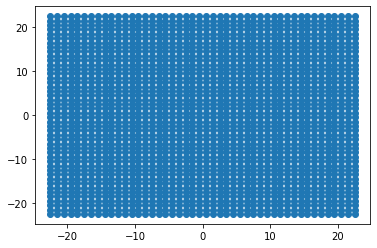

In [44]:
bit_grup=11

tam=ceil(np.sqrt(2**bit_grup))
if tam%2!=0:
  tam+=1

print(tam)
point = tam/2-0.5
x= np.linspace(-point,point,tam)

grid = np.array(np.meshgrid(x, x)).reshape((2,-1)).T


plt.scatter(grid[:,0],grid[:,1])


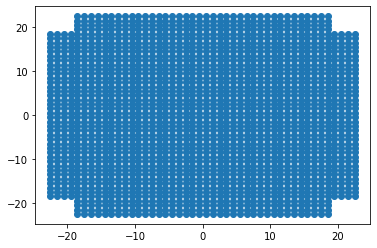

In [45]:

X= np.arange(len(grid)).reshape((-1,int(np.sqrt(len(grid)))))

k = int((bit_grup-3)/2)
grid2 = np.indices((k,k)).reshape((2,-1)).T

fuera=[]
delta=tam-k
fuera.append(X[grid2[:,0],grid2[:,1]])
fuera.append(X[grid2[:,0]+delta,grid2[:,1]])
fuera.append(X[grid2[:,0],grid2[:,1]]+delta)
fuera.append(X[grid2[:,0]+delta,grid2[:,1]]+delta)
grid = np.delete(grid,fuera,0)
plt.scatter(grid[:,0],grid[:,1])

#Quadrature Amplitude Modulation

Si se entiende claramente la modulación PSK. Se puede ver claramente que la modulación QAM es practicamente lo mismo. Y esta basa en los mismos principios que la modulación PSK. EL unico cambio es que no se asignan puntos en una circunferencia si no en el plano. Por lo tanto se termina modulando en amplitud y fase. Pero los algoritmos de codificación y decodificación funcionan igualmente con algunos pequeños cambios.